In [1]:
#standard Data Science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis

from collections import OrderedDict

#import gensim stuff
from gensim import corpora, models, similarities, matutils
from gensim.corpora import Dictionary

#import sklearn utilities
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

#other
import logging

%matplotlib inline
sns.set()
pyLDAvis.enable_notebook()

/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/anaconda3/lib/python3.5/importlib/_bootstrap.py

In [3]:
## Import the dataset, split into workable subset
reviews_full = pd.read_csv("/Users/anagiraldo-w/ds/Portfolio/Fine Food Reviews/data/reviews.csv")
reviews_bulk, reviews = train_test_split(reviews_full, test_size = 0.1, random_state = 42)
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...


In [4]:
reviews['Time'] = pd.to_datetime(reviews['Time'], unit='s')
reviews['Helpfulness'] = reviews['HelpfulnessNumerator']/reviews['HelpfulnessDenominator']
reviews = reviews.drop(['Id', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'ProfileName'], axis=1)
reviews = reviews.sort_values(by='Time').reset_index()
reviews.head()

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,index,ProductId,UserId,Score,Time,Summary,Text,Helpfulness
0,374342,B00004CI84,A1B2IZU1JLZA6,1,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",0.826087
1,230268,B00004RYGX,A1B2IZU1JLZA6,1,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",0.826087
2,451976,B00004CXX9,ACJR7EQF9S6FP,4,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,0.666667
3,149769,B00004S1C5,A1KXONFPU2XQ5K,5,2000-08-09,Very easy to use,This are so much easier to use than the Wilson...,1.000000
4,479722,B00005U2FA,A3TO9GEQEGKFDC,5,2002-05-01,I love this thing,The wine saver is great in so many ways. Obvio...,1.000000


In [5]:
reviews.isnull().sum()

index              0
ProductId          0
UserId             0
Score              0
Time               0
Summary            1
Text               0
Helpfulness    27004
dtype: int64

In [6]:
len(reviews['Helpfulness'])

56846

In [7]:
(len(reviews['Helpfulness']) - 27004)/len(reviews['Helpfulness'])

0.5249621785173979

In [8]:
# filter out textual data column

text = reviews['Text']

In [9]:
additional_stops = ['http', 'www', 'br', 'gp', 'com', 'href', 've', 'don', 'really', 'product', 'eat', 'amazon', 'bit', 'eating']
stop_words = ENGLISH_STOP_WORDS.union(additional_stops)

In [10]:
tfidf = TfidfVectorizer(ngram_range=(1, 1),
                        analyzer='word',
                        stop_words=stop_words,
                        strip_accents='unicode',
                        max_df=0.05
                       )


In [11]:
tfidf_vec = tfidf.fit_transform(text)
tfidf_vec.shape

(56846, 44337)

In [12]:
vec = CountVectorizer(ngram_range=(1, 1),
                      analyzer='word',
                      stop_words=stop_words,
                      strip_accents='unicode',
                      max_df=0.11
                     )
vec.fit(text)

counts_vec = vec.transform(text).transpose()

In [13]:
nmf = NMF(10)
nmf_vecs = nmf.fit_transform(tfidf_vec)

In [14]:
features = tfidf.get_feature_names()
topics = [[features[idx] for idx in np.flip(np.argsort(component)[-20:], axis=0)] for component in nmf.components_]

In [15]:
def print_topics(topics):
    for i,topic in enumerate(topics):
        print("Topic {}".format(i))
        print(", ".join(topic)+"\n")

In [16]:
print_topics(topics)

Topic 0
hot, sauce, spicy, milk, cocoa, heat, cold, chicken, iced, pasta, sauces, soup, noodles, pepper, cheese, rice, spice, powder, ice, chili

Topic 1
treats, dogs, treat, training, size, teeth, chew, puppy, chicken, pieces, toy, smell, picky, pet, large, smaller, bones, giving, chews, ingredients

Topic 2
chips, potato, salt, chip, bags, kettle, salty, vinegar, fat, popchips, crunchy, bbq, snack, regular, spicy, calories, baked, tortilla, healthier, sea

Topic 3
bars, snack, bar, protein, cereal, granola, low, tasty, calories, fat, fruit, kind, nuts, candy, high, crunchy, fiber, gluten, breakfast, ingredients

Topic 4
cat, cats, chicken, dry, canned, foods, wellness, diet, ingredients, vet, wet, feed, tuna, grain, feeding, cans, picky, fish, science, meat

Topic 5
cookies, gluten, cookie, ginger, chip, soft, oatmeal, wheat, texture, flour, kids, pamela, bread, broken, gf, family, products, crunchy, shortbread, package

Topic 6
strong, cups, bold, roast, bitter, blend, green, dark, 

Let's look at the distribution of the topics across the document

In [17]:
#df = pd.DataFrame([])
reviews['topics']=[nmf_vec.argmax() for nmf_vec in nmf_vecs]

reviews['topics'].value_counts()

8    26910
6     6976
3     4497
1     3735
9     3571
0     3086
4     2696
5     2243
2     1850
7     1282
Name: topics, dtype: int64

<BarContainer object of 10 artists>

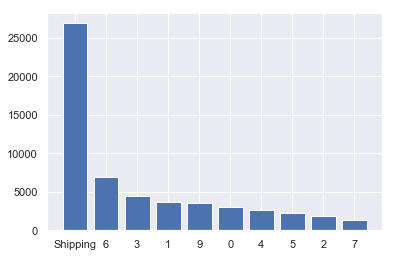

In [42]:
plt.bar(['Shipping', '6', '3', '1', '9', '0', '4', '5', '2', '7'], reviews['topics'].value_counts())

In [24]:
# reviews_stuff = reviews.loc[:,['topics', 'Time']]
reviews_stuff = reviews[['topics', 'Time']]
reviews_stuff.head()

,topics,Time
0,6,2000-01-19
1,6,2000-01-19
2,8,2000-02-26
3,8,2000-08-09
4,8,2002-05-01


In [25]:
reviews_stuff.to_csv('/Users/anagiraldo-w/ds/metis/metisgh/reviews_stuff.csv')

In [28]:
from wordcloud import WordCloud, STOPWORDS 
def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 1.0,
                          stopwords = stop_words # set or space-separated string
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(text)

TypeError: expected string or bytes-like object

In [ ]:
# df = pd.DataFrame([])
# df['topics']=[nmf_vec.argmax() for nmf_vec in nmf_vecs]
#  unicode(x.strip()) if x is not None else '' for x in row

## Let's Try LDA ##

In [ ]:
cv_corpus = matutils.Sparse2Corpus(counts_vec)
id2word = dict((v, k) for k, v in vec.vocabulary_.items())
lda = models.LdaModel(corpus=cv_corpus, num_topics=12, id2word=id2word, passes=10)
lda.print_topics()

In [ ]:
lda_dict = Dictionary(text)
lda_dict.compactify()
pyLDAvis.gensim.prepare(lda, cv_corpus, lda_dict)

## Now Let's Give LSI a Try

In [ ]:
# tfidf_corpus = matutils.Sparse2Corpus(tfidf_vec.transpose())

# id2word2 = dict((v, k) for k, v in tfidf.vocabulary_.items())

# lsi = models.LsiModel(tfidf_corpus, id2word=id2word2, num_topics=20)

In [ ]:
# lsi_corpus = lsi[tfidf_corpus]
# doc_vecs = [doc for doc in lsi_corpus]
# doc_vecs[0]

In [ ]:
# Index our test text blobs
#test_index = similarities.MatrixSimilarity(lsi_corpus)

## Combine Users ##

In [44]:
df_user = (reviews.groupby(['UserId'], as_index=False)
           .agg(OrderedDict(
               [('ProductId',(lambda x: list(x))),
                ('Text', 'sum')])))
df_user.head()

,UserId,ProductId,Text
0,#oc-R11O5J5ZVQE25C,[B005HG9ESG],This will be the bottle that you grab from the...
1,#oc-R149FDXLRARCWJ,[B008I1XPKA],I was fortunate enough to win a sampler box of...
2,#oc-R155JB2SA58E17,[B005HG9ESG],"If you love bottled water, and are looking for..."
3,#oc-R162D7S0A880MV,[B005HG9ESG],For those looking for a non-flavoured water be...
4,#oc-R19EJ3VEA88T6O,[B005HG9ET0],This is a very silky feeling water. I had to ...


In [45]:
user_text = df_user['Text']

tfidf2 = TfidfVectorizer(ngram_range=(1, 2),
                        analyzer='word',
                        stop_words=stop_words,
                        strip_accents='unicode',
                        max_df=0.1
                       )

user_corpus = tfidf2.fit_transform(user_text)

In [ ]:
nmf2 = NMF(8)
user_vecs = nmf2.fit_transform(user_corpus)

In [53]:
user_vec_df = pd.DataFrame(user_vecs)
user_vec_df.head()

,0,1,2,3,4,5,6,7
0,0.015588,0.000985,0.00000,0.0,0.0,0.000138,0.000000,0.000000
1,0.000000,0.000000,0.00000,0.0,0.0,0.020656,0.000000,0.004916
2,0.019314,0.000835,0.00000,0.0,0.0,0.000000,0.000000,0.000000
3,0.016261,0.000000,0.00000,0.0,0.0,0.000870,0.000000,0.000000
4,0.019331,0.000573,0.00253,0.0,0.0,0.000791,0.003403,0.002582


In [54]:
user_vec_df.to_csv('/Users/anagiraldo-w/ds/metis/metisgh/user_vectors.csv')

In [47]:
user_features = tfidf2.get_feature_names()
user_topics = [[user_features[idx] for idx in np.flip(np.argsort(component)[-20:], axis=0)] for component in nmf2.components_]

In [48]:
print_topics(user_topics)

Topic 0
water, sugar, sweet, tastes, drink, coconut, oil, add, milk, sauce, mix, stuff, cereal, hot, used, organic, healthy, does, fruit, way

Topic 1
tea, green, green tea, teas, drink, iced, tea bags, bags, black, iced tea, chai, black tea, love tea, stash, earl, grey, earl grey, drinking, hot, loose

Topic 2
dog, treats, dogs, loves, treat, dog food, dog loves, dogs love, training, small, teeth, chew, puppy, toy, old, dog treats, healthy, chicken, size, pet

Topic 3
gluten, free, gluten free, cookies, bread, flour, pasta, wheat, mix, sugar free, products, cookie, pretzels, free diet, best gluten, celiac, gf, texture, free products, pamela

Topic 4
chocolate, butter, peanut, peanut butter, bars, bar, cookies, dark chocolate, dark, hot chocolate, hot, cookie, calories, fat, cocoa, pb2, protein, milk, like peanut, snack

Topic 5
cup, cups, strong, cup coffee, bold, roast, keurig, blend, dark, bitter, decaf, french, smooth, coffees, starbucks, favorite, mountain, morning, green mountain

In [ ]:
from sklearn.cluster import DBSCAN
dbscan_clusters = DBSCAN()
dbscan_clusters.fit_predict(user_vecs)

In [ ]:
centers = dbscan_clusters.components_ 

#sns.scatterplot(X[:,0], X[:,1], hue=df.sentiment)
plt.scatter(centers[:,0], centers[0,:],color = 'purple') 
plt.scatter(centers[:,0], centers[0,:],color = 'red')
plt.title('First Two Principle Components, With 2-Means Cluster Centers')

In [ ]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(user_corpus)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)


In [ ]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = user_corpus[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = user_corpus[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Combine Products ##

In [29]:
df_products = (reviews.groupby(['ProductId'], as_index=False)
           .agg(OrderedDict(
               [('UserId',(lambda x: list(x))),
                ('Text', 'sum')])))
df_products.head()

,ProductId,UserId,Text
0,0006641040,"[A3E7R866M94L0C, AYZ0PR5QZROD1]",This book has been a favorite of mine since I ...
1,2734888454,[A13ISQV0U9GZIC],My dogs loves this chicken but its a product f...
2,7310172001,"[AOLDDV8Y96TSB, A16GY2RCF410DT, A223KNNTFHHIM7...",Our dog would do ANYTHING for these treats! Ha...
3,7310172101,"[A1JTZ9K2RZKAA4, A14YBOI1XSJ0UP, A1DIS7PF5AA5V...",I have a chihuahua that is the pickiest eater ...
4,B00002N8SM,"[A1L227LG53GTLB, A23KO0L75SEQ3K, A19Q006CSFT01...",In the time I spent waiting for my order of th...


In [30]:
products_text = df_products['Text']

tfidf2 = TfidfVectorizer(ngram_range=(1, 1),
                        analyzer='word',
                        stop_words=stop_words,
                        strip_accents='unicode',
                        min_df=0.05
                       )

In [31]:
product_corpus = tfidf2.fit_transform(products_text)

nmf3 = NMF(10)

product_vecs = nmf3.fit_transform(product_corpus)

product_features = tfidf2.get_feature_names()
product_topics = [[product_features[idx] for idx in np.flip(np.argsort(component)[-20:], axis=0)] for component in nmf3.components_]

print_topics(product_topics)

Topic 0
like, taste, sugar, sweet, just, tastes, tried, try, free, better, does, little, think, bad, texture, calories, doesn, drink, snack, know

Topic 1
tea, green, drink, cup, bags, strong, hot, day, flavor, organic, bag, water, enjoy, favorite, nice, milk, morning, tastes, box, wonderful

Topic 2
coffee, cup, strong, drink, morning, best, tried, favorite, enjoy, house, taste, try, flavor, price, like, brand, green, brands, extra, new

Topic 3
food, dog, dogs, loves, chicken, old, dry, treat, foods, ingredients, healthy, diet, quality, year, like, small, natural, bag, day, little

Topic 4
chocolate, milk, hot, delicious, sweet, best, free, sugar, treat, box, calories, perfect, just, mix, tasted, make, texture, loved, wonderful, pack

Topic 5
buy, price, order, time, store, box, just, ordered, bought, bag, shipping, local, best, arrived, grocery, got, stores, received, item, pack

Topic 6
love, dogs, favorite, treat, just, absolutely, sweet, delicious, perfect, snack, stuff, best, he

In [32]:
df = pd.DataFrame([])
df['product_topics']=[product_vec.argmax() for product_vec in product_vecs]

df['product_topics'].value_counts()

5    4503
9    2471
0    2390
8    2315
3    2214
7    2046
1    1843
6    1807
2    1711
4    1218
Name: product_topics, dtype: int64

<BarContainer object of 10 artists>

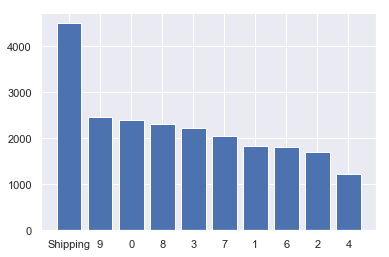

In [43]:
plt.bar(['Shipping', '9', '0', '8', '3', '7', '1', '6', '2', '4'], df['product_topics'].value_counts())

In [ ]:
df.shape

In [ ]:
df_products = df_products.merge(df, on=df.index)
df_products.head(20)

In [ ]:
tfidf3 = TfidfVectorizer(ngram_range=(1, 1),
                        analyzer='word',
                        stop_words=stop_words,
                        strip_accents='unicode',
                        max_df=0.5,
                        min_df=0.1
                       )

shipping_corpus = tfidf3.fit_transform(text)

nmf4 = NMF(5)

In [ ]:
shipping_vecs = nmf4.fit_transform(shipping_corpus)

shipping_features = tfidf3.get_feature_names()
shipping_topics = [[shipping_features[idx] for idx in np.flip(np.argsort(component)[-20:], axis=0)] for component in nmf4.components_]

print_topics(shipping_topics)

In [ ]:
nmf4.components_

In [ ]:
df = pd.DataFrame([])
df['product_topics']=[product_vec.argmax() for product_vec in product_vecs]

df['product_topics'].value_counts()
